# Task definition
Implement LSTM Sentiment Tagger for imdb reviews dataset.

1. (5pt) Fill missing code below
    * 1pt implement vectorization
    * 2pt implement \_\_init\_\_ and forward methods of models
    * 2pt implement collate function
2. (4pt) Implement training loop, choose proper loss function, use clear ml for max points.
    * 2pts is a baseline for well written, working code
    * 2pts if clear ml used properly
3. (3pt) Train the models (find proper hyperparams). Make sure you are not overfitting or underfitting. Visualize training of your best model (plot training, and test loss/accuracy in time). Your model should reach at least 87% accuracy. For max points it should exceed 89%. 
    * 1pt for accuracy above 89%
    * 1pt for accuracy above 87%
    * 1pt for visualizations

Remarks:
* Use embeddings of size 50
* Use 0.5 threshold when computing accuracy.
* Use supplied dataset for training and evaluation.
* You do not have to use validation set.
* You should monitor overfitting during training.
* For max points use clear ml to store and manage logs from your experiments. 
* We encourage to use pytorch lightning library (Addtional point for using it - however the sum must not exceed 12)

[Clear ML documentation](https://clear.ml/docs/latest/docs/)

[Clear ML notebook exercise from bootcamp](https://colab.research.google.com/drive/1wtLb4gg8beLS7smcyJlOZppn6_rQvSxL?usp=sharing)

In [ ]:
!pip install clearml
!pip install pytorch-lightning

In [6]:
import pandas as pd
from tqdm.auto import tqdm
import torchtext
from clearml import Task

import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [7]:
web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = ''#@param {type:"string"}
secret_key = ''#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1hK-3iiRPlbePb99Fe-34LJNZ5yB-nduq
!tar -xvzf imdb_dataset.gz
data = pd.read_csv("imdb_dataset.csv")

Downloading...
From: https://drive.google.com/uc?id=1hK-3iiRPlbePb99Fe-34LJNZ5yB-nduq
To: /content/imdb_dataset.gz
100% 77.0M/77.0M [00:00<00:00, 100MB/s]
imdb_dataset.csv


In [ ]:
PADDING_VALUE = 0

class NaiveVectorizer:
    def __init__(self, tokenized_data, **kwargs):
        """Converts data from string to vector of ints that represent words. 
        Prepare lookup dict (self.wv) that maps token to int. Reserve index 0 for padding.
        """
        tokenized_data = [seq.split() for seq in tokenized_data]
        tokens_set = {token for seq in tokenized_data for token in seq}
        self.wv = {token: index for index, token in enumerate(tokens_set, 1)}
        self.wv[''] = PADDING_VALUE

    def vectorize(self, tokenized_seq):
        """Converts sequence of tokens into sequence of indices.
        If the token does not appear in the vocabulary(self.wv) it is omitted.
        Returns torch tensor of shape (seq_len,) and type long."""

        encoding = [self.wv[token] for token in tokenized_seq if token in self.wv]
        return torch.as_tensor(encoding, dtype=torch.long)


class ImdbDataset(Dataset):
    SPLIT_TYPES = ["train", "test", "unsup"]

    def __init__(self, data, preprocess_fn, split="train"):
        super(ImdbDataset, self).__init__()
        if split not in self.SPLIT_TYPES:
            raise AttributeError(f"No such split type: {split}")

        self.split = split
        self.label = [i for i, c in enumerate(data.columns) if c == "sentiment"][0]
        self.data_col = [i for i, c in enumerate(data.columns) if c == "tokenized"][0]
        self.data = data[data["split"] == self.split]
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.preprocess_fn(self.data.iloc[idx, self.data_col].split())
        label = self.data.iloc[idx, self.label]
        return (seq, label)

naive_vectorizer = NaiveVectorizer(data.loc[data["split"] == "train", "tokenized"])

def get_datasets():
    train_dataset = ImdbDataset(data, naive_vectorizer.vectorize)
    test_dataset = ImdbDataset(data, naive_vectorizer.vectorize, split="test")
        
    return train_dataset, test_dataset

def custom_collate_fn(pairs):
    """This function is supposed to be used by dataloader to prepare batches
    Input: list of tuples (sequence, label)
    Output: sequences_padded_to_the_same_lengths, original_lengths_of_sequences, labels.
    torch.nn.utils.rnn.pad_sequence might be useful here
    """
    lengths = torch.as_tensor([len(pair[0]) for pair in pairs])
    sequences = nn.utils.rnn.pad_sequence([pair[0] for pair in pairs], padding_value=PADDING_VALUE)
    labels = torch.as_tensor([pair[1] for pair in pairs])

    return sequences, lengths, labels

In [ ]:
"""Implement LSTMSentimentTagger.
The model should use a LSTM module.
Use torch.nn.utils.rnn.pack_padded_sequence to optimize processing of sequences.
When computing vocab_size of embedding layer remember that padding_symbol counts to the vocab.
Use sigmoid activation function.
"""
class LSTMSentimentTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, classes):
        super(LSTMSentimentTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        # LSTM gives at best 88.9 % accuracy, GRU gives accuracy above 90 %
        self.recurrent = nn.GRU(embedding_dim, hidden_dim, num_layers=2, dropout=0.5, batch_first=True)
        # self.recurrent = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout=0.5, batch_first=True)
        self.linears = nn.Sequential(
            nn.BatchNorm1d(hidden_dim),
            nn.RReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, classes)
        )

    def forward(self, sequences, lengths):
        x = sequences.permute(1, 0)
        x = self.embedding_layer(x)
        x = self.dropout(x)
        recurrent_out, _ = self.recurrent(x)
        x = torch.stack([batch_el[length - 1] for batch_el, length in zip(recurrent_out, lengths)])
        x = self.linears(x)
        x = x.view(-1)
        return x

class TaggerLightningModule(pl.LightningModule):
    def __init__(self, model, lr, loss_fn):
        super(TaggerLightningModule, self).__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = loss_fn

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=0.1)

    def training_step(self, batch, batch_idx):
        sequences, lengths, labels = batch
        output = self.model(sequences, lengths)
        loss = self.loss_fn(output, labels)
        correct_count = torch.sum(torch.abs(labels - torch.sigmoid(output)) < ACCURACY_THRESHOLD).item()

        batch_size = sequences.shape[1]
        loss = loss / batch_size
        accuracy = 100. * correct_count / batch_size

        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True, batch_size=batch_size)
        self.log("train_accuracy", accuracy, on_epoch=True, on_step=False, prog_bar=True, batch_size=batch_size)

        return {'loss': loss, 'accuracy': accuracy}

    def validation_step(self, batch, batch_idx):
        sequences, lengths, labels = batch
        output = self.model(sequences, lengths)
        loss = self.loss_fn(output, labels)
        correct_count = torch.sum(torch.abs(labels - torch.sigmoid(output)) < ACCURACY_THRESHOLD).item()

        batch_size = sequences.shape[1]
        loss = loss / batch_size
        accuracy = 100. * correct_count / batch_size

        self.log("test_loss", loss, on_epoch=True, on_step=False, prog_bar=True, batch_size=batch_size)
        self.log("test_accuracy", accuracy, on_epoch=True, on_step=False, prog_bar=True, batch_size=batch_size)

        return {'loss': loss, 'accuracy': accuracy}

# Trainig loop and visualizations


In [ ]:
ACCURACY_THRESHOLD = 0.5

config = {
    'hidden_dim': 32,
    'embedding_dim': 50,
    'batch_size': 500,
    'test_batch_size': 500,
    'epochs': 10,
    'lr': 0.01
}

dataset_kwargs = {
    'num_workers': 2,
    'pin_memory': True,
    'collate_fn': custom_collate_fn
}
train_kwargs = {'batch_size': config['batch_size'], 'shuffle': True, **dataset_kwargs}
test_kwargs = {'batch_size': config['test_batch_size'], **dataset_kwargs}

train_dataset, test_dataset = get_datasets()
train_loader = DataLoader(train_dataset, **train_kwargs)
test_loader = DataLoader(test_dataset, **test_kwargs)

task = Task.init(project_name='Homework_3', task_name='Task', reuse_last_task_id=False, continue_last_task=False)
task.connect(config)

net = LSTMSentimentTagger(config['embedding_dim'], config['hidden_dim'], len(naive_vectorizer.wv), 1)
loss_function = nn.BCEWithLogitsLoss()
model = TaggerLightningModule(net, config['lr'], loss_function)
trainer = pl.Trainer(gpus=1, log_every_n_steps=25, max_epochs=config['epochs'])
trainer.fit(model, train_loader, test_loader)

task.mark_completed()
task.close()

ClearML Task: created new task id=8dc690a1511845578289d3ae646c13e5
ClearML results page: https://app.community.clear.ml/projects/b49ec7eefc1e4bbea52b24ecad560296/experiments/8dc690a1511845578289d3ae646c13e5/output/log


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params
------------------------------------------------
0 | model   | LSTMSentimentTagger | 4.4 M 
1 | loss_fn | BCEWithLogitsLoss   | 0     
------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.464    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2022-01-15 14:09:03,852 - clearml.Task - INFO - Waiting for repository detection and full package requirement analysis


In [8]:
def annotate_plot(plot, xs, ys, precision=2):
    for x,y in zip(xs, ys):
        label = '{:.{}f}'.format(y, precision)
        plot.annotate(label, (x,y), textcoords='offset points',
                     xytext=(0,10), ha='center')

def plot_results(title, loss_data, acc_data):
    fig, (loss, acc) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(title, fontsize=20, y=0.92)
    loss.set_title(loss_data['name'], size=16)
    acc.set_title(acc_data['name'], size=16)

    loss.plot(loss_data['x'], loss_data['y'], 'r.-', zorder=10)
    acc.plot(acc_data['x'], acc_data['y'], 'b.-', zorder=10)

    annotate_plot(loss, loss_data['x'], loss_data['y'], precision=5)
    annotate_plot(acc, acc_data['x'], acc_data['y'])

    plt.show()

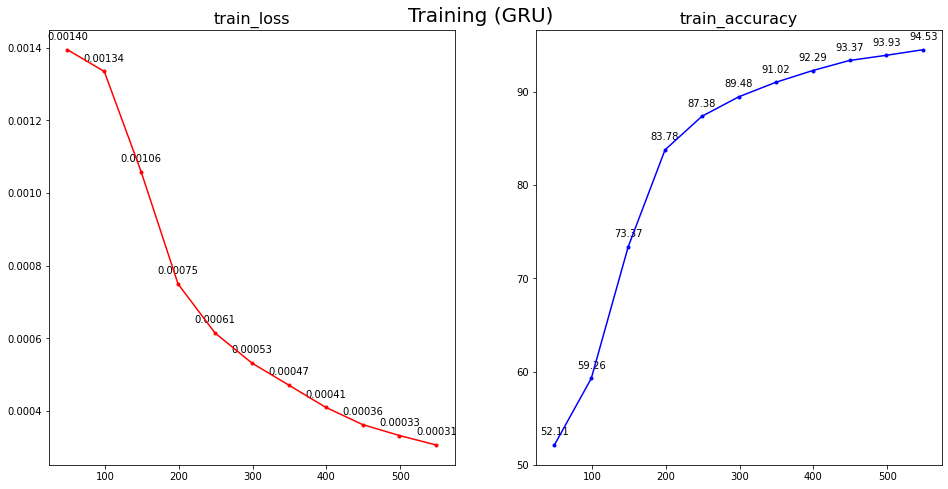

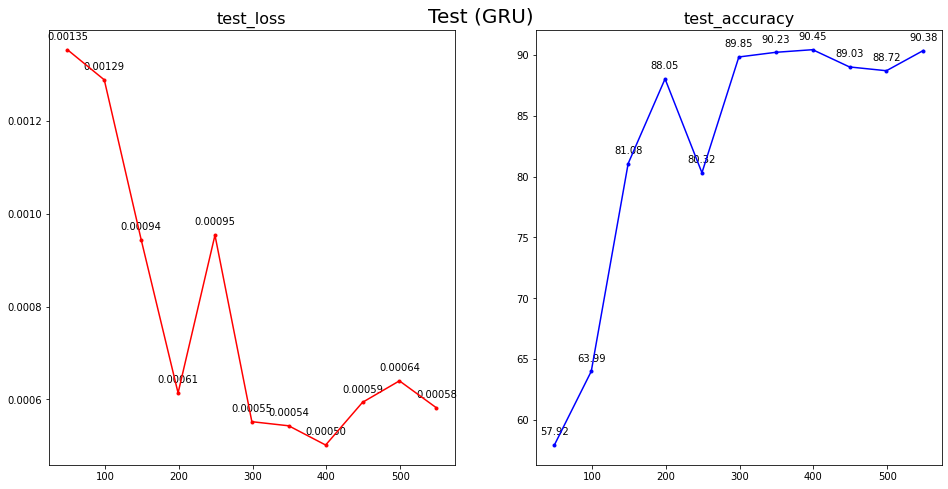

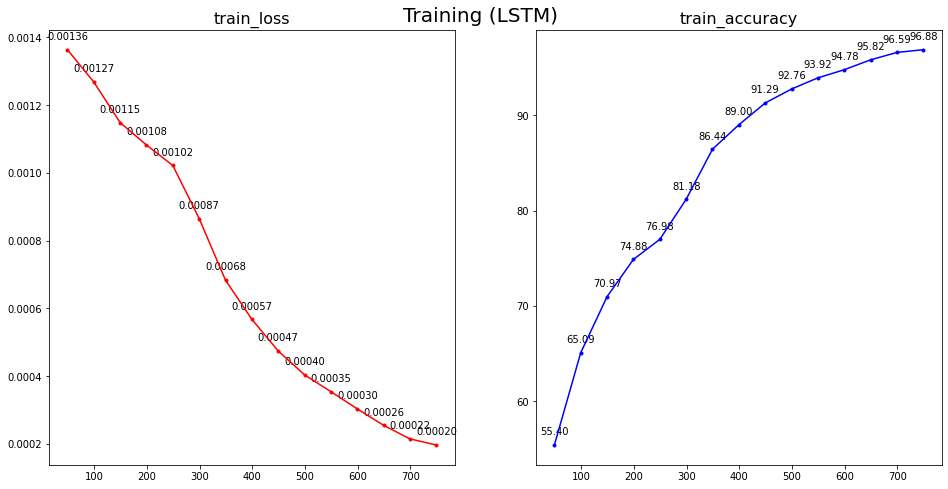

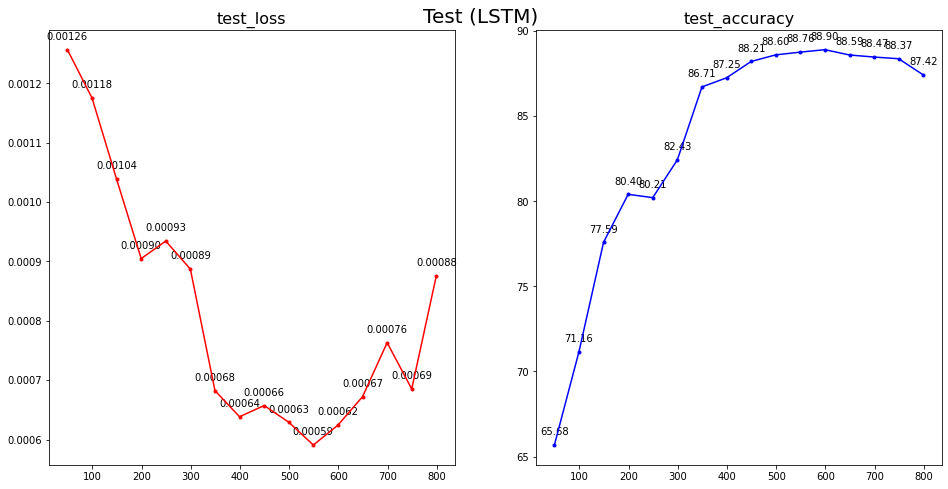

In [9]:
# GRU
best_task = Task.get_task('49efe358e6fb4566b097ffefa2b8b643')
scalar_graphs = best_task.get_reported_scalars()

plot_results('Training (GRU)', scalar_graphs['train_loss']['train_loss'], scalar_graphs['train_accuracy']['train_accuracy'])
plot_results('Test (GRU)', scalar_graphs['test_loss']['test_loss'], scalar_graphs['test_accuracy']['test_accuracy'])

# LSTM
best_task = Task.get_task('25993dceeda84ef897f02c982975910a')
scalar_graphs = best_task.get_reported_scalars()

plot_results('Training (LSTM)', scalar_graphs['train_loss']['train_loss'], scalar_graphs['train_accuracy']['train_accuracy'])
plot_results('Test (LSTM)', scalar_graphs['test_loss']['test_loss'], scalar_graphs['test_accuracy']['test_accuracy'])